# Traffic Sign Recognizer with Convolutional Neural Network

In [1]:
# allow import data
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Counting objects: 6, done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (6/6), done.


In [2]:
!ls german-traffic-signs
# note that the data are all pickled

signnames.csv test.p        train.p       valid.p


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import cv2

from keras.callbacks import LearningRateScheduler, ModelCheckpoint

%matplotlib inline

In [25]:
np.random.seed(0)

In [26]:
# reading all data as binary
with open("german-traffic-signs/test.p", "rb") as f: 
    test_data = pickle.load(f)
with open("german-traffic-signs/train.p", "rb") as f:
    train_data = pickle.load(f)
with open("german-traffic-signs/valid.p", "rb") as f:
    val_data = pickle.load(f)
    
print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_test, y_test = test_data['features'], test_data['labels']
X_val, y_val = val_data['features'], val_data['labels']

<class 'dict'>


In [27]:
# get familiar with the structure
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [28]:
# check dimensions
assert(X_train.shape[0] == y_train.shape[0]), "Stop"
assert(X_test.shape[0] == y_test.shape[0]), "Stop"
assert(X_val.shape[0] == y_val.shape[0]), "Stop"
assert(X_train.shape[1:] == (32, 32, 3)), "Stop"
assert(X_test.shape[1:] == (32, 32, 3)), "Stop"
assert(X_val.shape[1:] == (32, 32, 3)), "Stop"

   ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


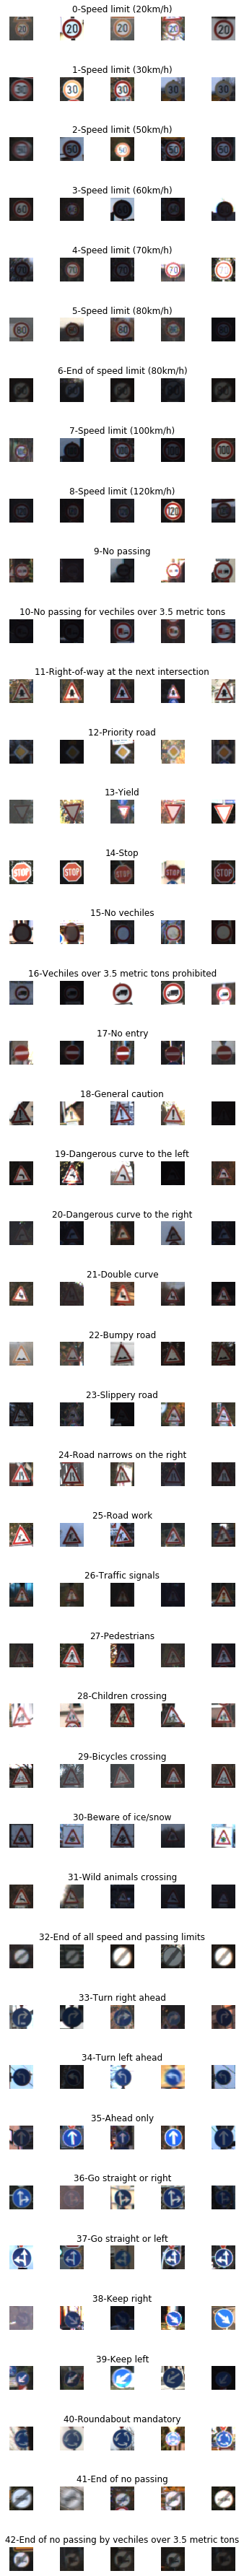

In [29]:
# matplotlib is the hardest programming language
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data.head())

num_of_samples=[]

cols = 5
num_classes = 43

# each class 5 columns
fig, axes = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows(): # (index, series)
        x_selected = X_train[y_train == j]
        axes[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :,:], cmap=plt.get_cmap("gray"))
        axes[j][i].axis("off")
        if i == 2:
            axes[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))
        

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


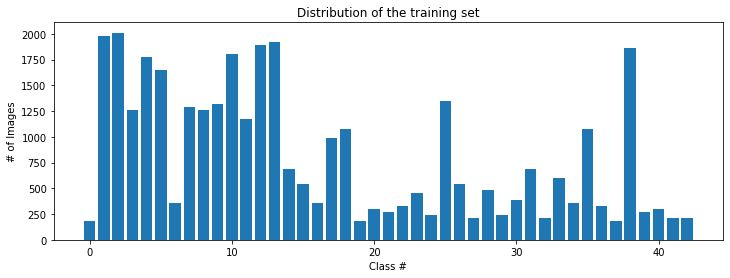

In [30]:
# plot histogram of data distribution
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training set")
plt.xlabel("Class #")
plt.ylabel("# of Images")
plt.show()
# shows the amount of dataset is quite nonuniform

(32, 32)


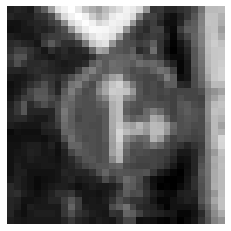

In [32]:
# color is not an important feature to look for
# traffic signs do not have the same shape (color blind people)
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img, cmap='Greys_r')
plt.axis("off")
print(img.shape)

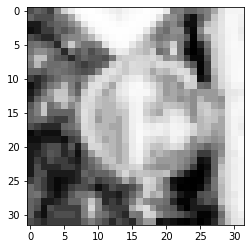

In [33]:
# histogram equalization, reassign intensities more uniformly
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img, cmap='Greys_r')

In [34]:
# pipline for preprocessing image
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img / 255.0
    return img

# preprocess training set
X_train = np.array(list(map(preprocessing, X_train)))
X_test = np.array(list(map(preprocessing, X_test)))
X_val = np.array(list(map(preprocessing, X_val)))

In [35]:
# sanity check
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [36]:
from keras.preprocessing.image import ImageDataGenerator

# define generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2, shear_range=0.1,rotation_range=10)

datagen.fit(X_train)

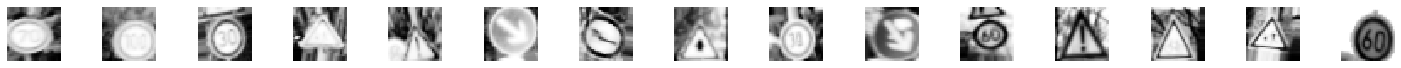

In [38]:
# get batch and check if the preprocess worked
batches = datagen.flow(X_train, y_train, batch_size=32)
X_batch, y_batch = next(batches)

fig, axes = plt.subplots(1, 15, figsize=(20,5))
fig.tight_layout()

for i in range(15):
    axes[i].imshow(X_batch[i].reshape(32, 32), cmap='Greys_r')
    axes[i].axis("off")

In [39]:
# sanity check
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [40]:
# one hot vector encoding
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [41]:
# define model
def model():
    model = Sequential()
    model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(60, (5, 5), activation='relu'))
    model.add(MaxPooling2D())
    
    model.add(Conv2D(30, (3, 3), activation="relu"))
    model.add(Conv2D(30, (3, 3), activation="relu"))
    model.add(MaxPooling2D())   
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['acc'])
    return model

In [42]:
model = model()
print(model.summary())

W0714 10:39:50.007037 4607464896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 10:39:50.025303 4607464896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 10:39:50.029119 4607464896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0714 10:39:50.056332 4607464896 deprecation_wrapper.py:119] From /anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0714 10:39:50.110409 4607464896 deprecation_wrapper.py:119] From /anaconda

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 480)               0         
__________

In [ ]:
# train
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50), steps_per_epoch=2000, epochs=10, validation_data=(X_val,y_val), shuffle=1)

Text(0.5, 0, 'epoch')

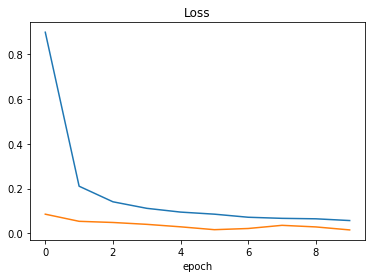

In [120]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

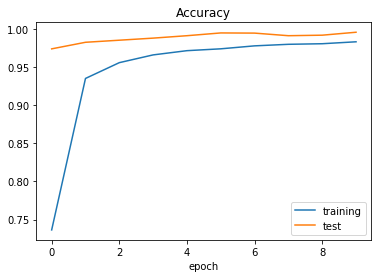

In [121]:
# plot accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [0]:
score = model.evaluate(X_test, y_test, verbose=0)

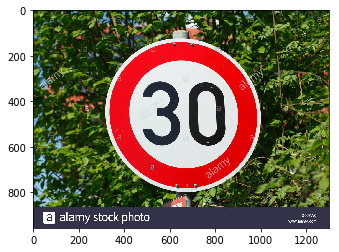

In [123]:
import requests
from PIL import Image
url = "https://c8.alamy.com/comp/G667W0/road-sign-speed-limit-30-kmh-zone-passau-bavaria-germany-G667W0.jpg"

# request for the online image
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap("gray"))

(32, 32)


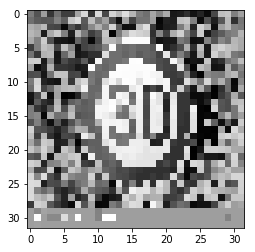

In [124]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [0]:
img = img.reshape(1,32,32,1)

In [126]:
prediction = model.predict_classes(img)
data["SignName"][prediction]

1    Speed limit (30km/h)
Name: SignName, dtype: object